<a href="https://colab.research.google.com/github/pranavpm99/LEETCODE-BY-PM/blob/main/DB2_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The strats mentioned below the code is not exactly same as used in reality, the purpose is to show the choosing of the stratefy based on max drawdown and sharpness

[*********************100%***********************]  1 of 1 completed


Best strategy: Covered Call


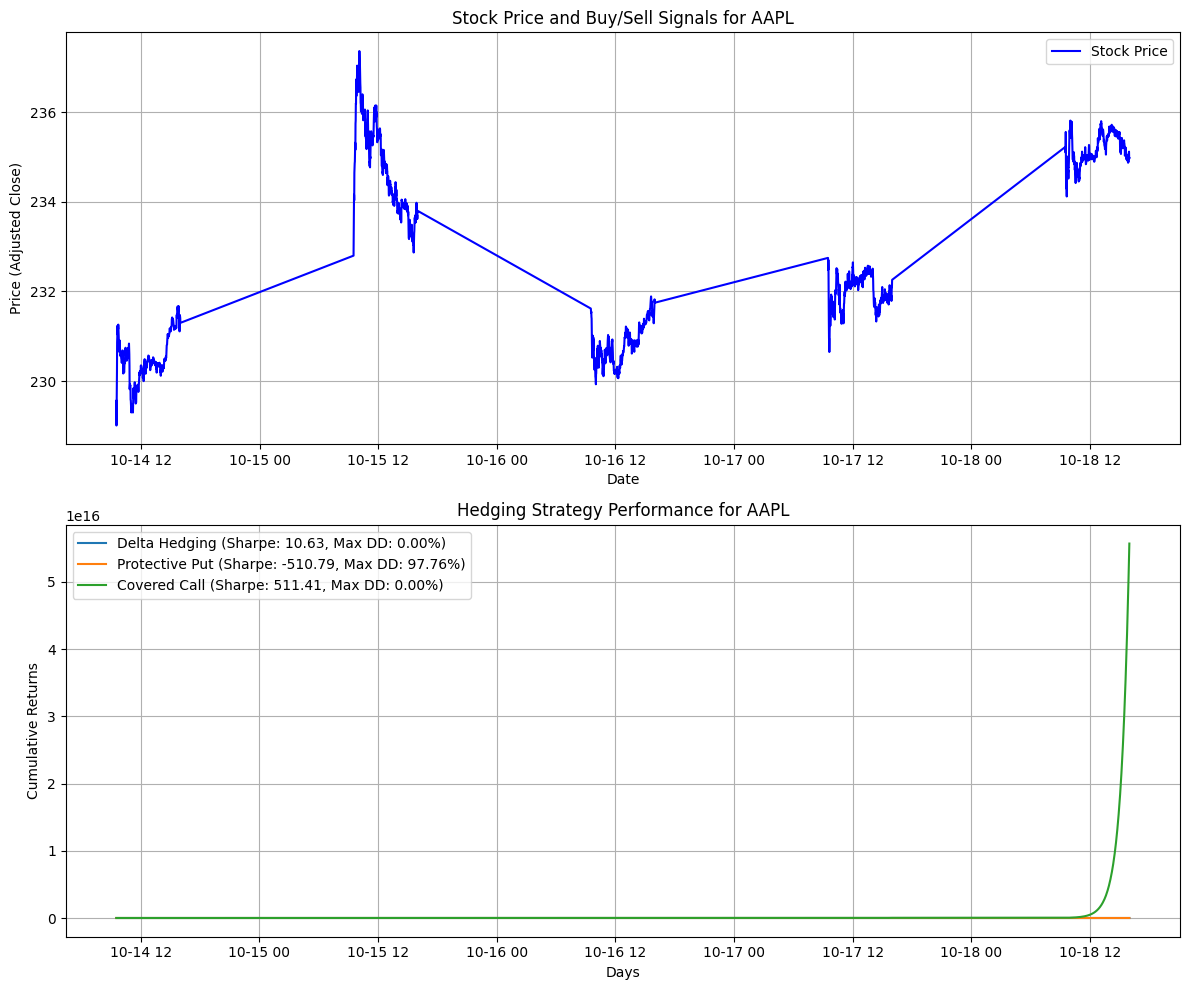

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fetching of data
def fetch_data(ticker):
    stock_data = yf.download(ticker, period='5d', interval='1m')
    stock_data['Returns'] = stock_data['Adj Close'].pct_change()
    return stock_data

#hedging strategies

def delta_hedging(stock_data):
    delta = np.where(stock_data['Returns'] > 0, 1, -1)  # Simplified
    hedge_returns = delta * stock_data['Returns']
    return hedge_returns
    # pass

def protective_put(stock_data, put_cost=0.02):
    stock_data['Hedge'] = stock_data['Returns'] - put_cost
    stock_data['Hedge'] = np.where(stock_data['Returns'] < -0.05, 0, stock_data['Hedge'])  # Assuming significant drop
    return stock_data['Hedge']
    # pass

def covered_call(stock_data, call_premium=0.02):
    stock_data['Hedge'] = stock_data['Returns'] + call_premium
    return stock_data['Hedge']
    # pass

# Evaluate
def evaluate_strategy(hedge_returns):
    cumulative_returns = (1 + hedge_returns).cumprod() - 1
    sharpe_ratio = np.mean(hedge_returns) / np.std(hedge_returns) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
    return cumulative_returns, sharpe_ratio, max_drawdown
    pass

# comparision
def compare_strategies(ticker):
    stock_data = fetch_data(ticker)

    strategies = {
        "Delta Hedging": delta_hedging(stock_data),
        "Protective Put": protective_put(stock_data),
        "Covered Call": covered_call(stock_data)
    }

    results = {}
    for strategy, returns in strategies.items():
        cumulative_returns, sharpe, drawdown = evaluate_strategy(returns)
        results[strategy] = {'Sharpe Ratio': sharpe, 'Max Drawdown': drawdown, 'Cumulative Returns': cumulative_returns}

    best_strategy = max(results, key=lambda x: results[x]['Sharpe Ratio'])

    return stock_data, results, best_strategy

# plot graph
def compare_and_plot_strategies(ticker):
    stock_data, results, best_strategy = compare_strategies(ticker)

    # print("Results of all strategies:", results)
    print("Best strategy:", best_strategy)

    fig, axs = plt.subplots(2, figsize=(12, 10))

    axs[0].plot(stock_data.index, stock_data['Close'], label='Stock Price', color='blue')

    axs[0].set_title(f'Stock Price and Buy/Sell Signals for {ticker}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (Adjusted Close)')
    axs[0].legend()
    axs[0].grid(True)

    for strategy_name, metrics in results.items():
        cumulative_returns = metrics['Cumulative Returns']
        sharpe = metrics['Sharpe Ratio']
        drawdown = metrics['Max Drawdown']

        # Plot the cumulative returns of the strategy
        axs[1].plot(cumulative_returns, label=f"{strategy_name} (Sharpe: {sharpe:.2f}, Max DD: {drawdown:.2%})")

    axs[1].set_title(f'Hedging Strategy Performance for {ticker}')
    axs[1].set_xlabel('Days')
    axs[1].set_ylabel('Cumulative Returns')
    axs[1].legend()
    axs[1].grid(True)
    plt.show()

# Example usage
ticker = 'AAPL'
compare_and_plot_strategies(ticker)


[*********************100%***********************]  1 of 1 completed


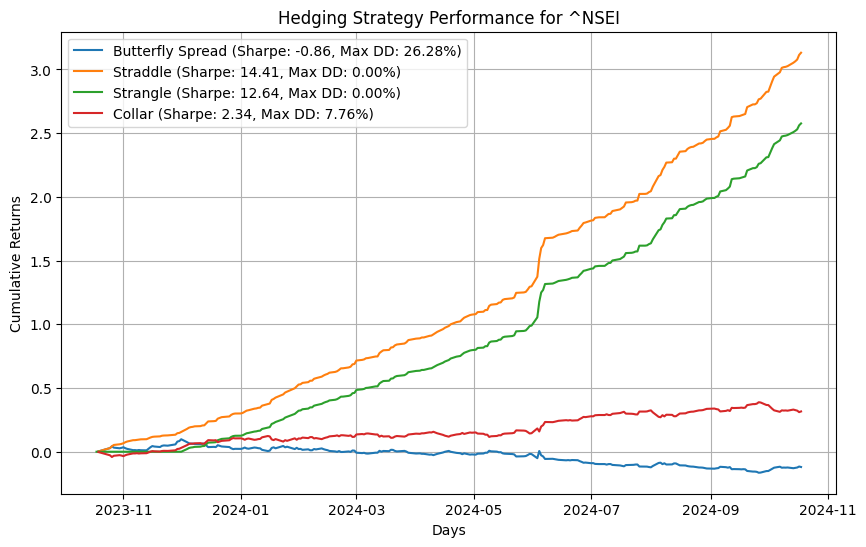

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fetch data
def fetch_data(ticker):
    stock_data = yf.download(ticker, period='1y', interval='1d')
    stock_data['Returns'] = stock_data['Adj Close'].pct_change()
    return stock_data

# Step 2: Define hedging strategies

# Butterfly Spread
def butterfly_spread(stock_data, itm=0.95, atm=1.0, otm=1.05):
    stock_data['Hedge'] = np.where(stock_data['Adj Close'] < itm * stock_data['Adj Close'].iloc[0], -1, 0)
    stock_data['Hedge'] += np.where((stock_data['Adj Close'] >= atm * stock_data['Adj Close'].iloc[0]) &
                                    (stock_data['Adj Close'] <= otm * stock_data['Adj Close'].iloc[0]), 2, -1)
    return stock_data['Hedge'] * stock_data['Returns']

# Straddle
def straddle(stock_data):
    stock_data['Hedge'] = np.abs(stock_data['Returns'])
    return stock_data['Hedge']

# Strangle
def strangle(stock_data, lower_bound=0.95, upper_bound=1.05):
    stock_data['Hedge'] = np.where((stock_data['Adj Close'] < lower_bound * stock_data['Adj Close'].iloc[0]) |
                                   (stock_data['Adj Close'] > upper_bound * stock_data['Adj Close'].iloc[0]),
                                   np.abs(stock_data['Returns']), 0)
    return stock_data['Hedge']

# Collar
def collar(stock_data, put_cost=0.02, call_premium=0.02):
    stock_data['Hedge'] = np.where(stock_data['Returns'] < -0.05, -put_cost, stock_data['Returns'])
    stock_data['Hedge'] = np.where(stock_data['Returns'] > 0.05, stock_data['Hedge'] + call_premium, stock_data['Hedge'])
    return stock_data['Hedge']

# Step 3: Evaluation metrics
def evaluate_strategy(hedge_returns):
    cumulative_returns = (1 + hedge_returns).cumprod() - 1
    sharpe_ratio = np.mean(hedge_returns) / np.std(hedge_returns) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
    return cumulative_returns, sharpe_ratio, max_drawdown

# Step 4: Plot strategies and compare
def compare_and_plot_strategies(ticker):
    stock_data = fetch_data(ticker)

    # Apply hedging strategies
    strategies = {
        "Butterfly Spread": butterfly_spread(stock_data),
        "Straddle": straddle(stock_data),
        "Strangle": strangle(stock_data),
        "Collar": collar(stock_data)
    }

    # Plot cumulative returns
    plt.figure(figsize=(10,6))

    for strategy_name, hedge_returns in strategies.items():
        cumulative_returns, sharpe, drawdown = evaluate_strategy(hedge_returns)

        # Plot the cumulative returns of the strategy
        plt.plot(cumulative_returns, label=f"{strategy_name} (Sharpe: {sharpe:.2f}, Max DD: {drawdown:.2%})")

    # Plot settings
    plt.title(f'Hedging Strategy Performance for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
ticker = '^NSEI'
compare_and_plot_strategies(ticker)


# Without ARIMA model

[*********************100%***********************]  1 of 1 completed


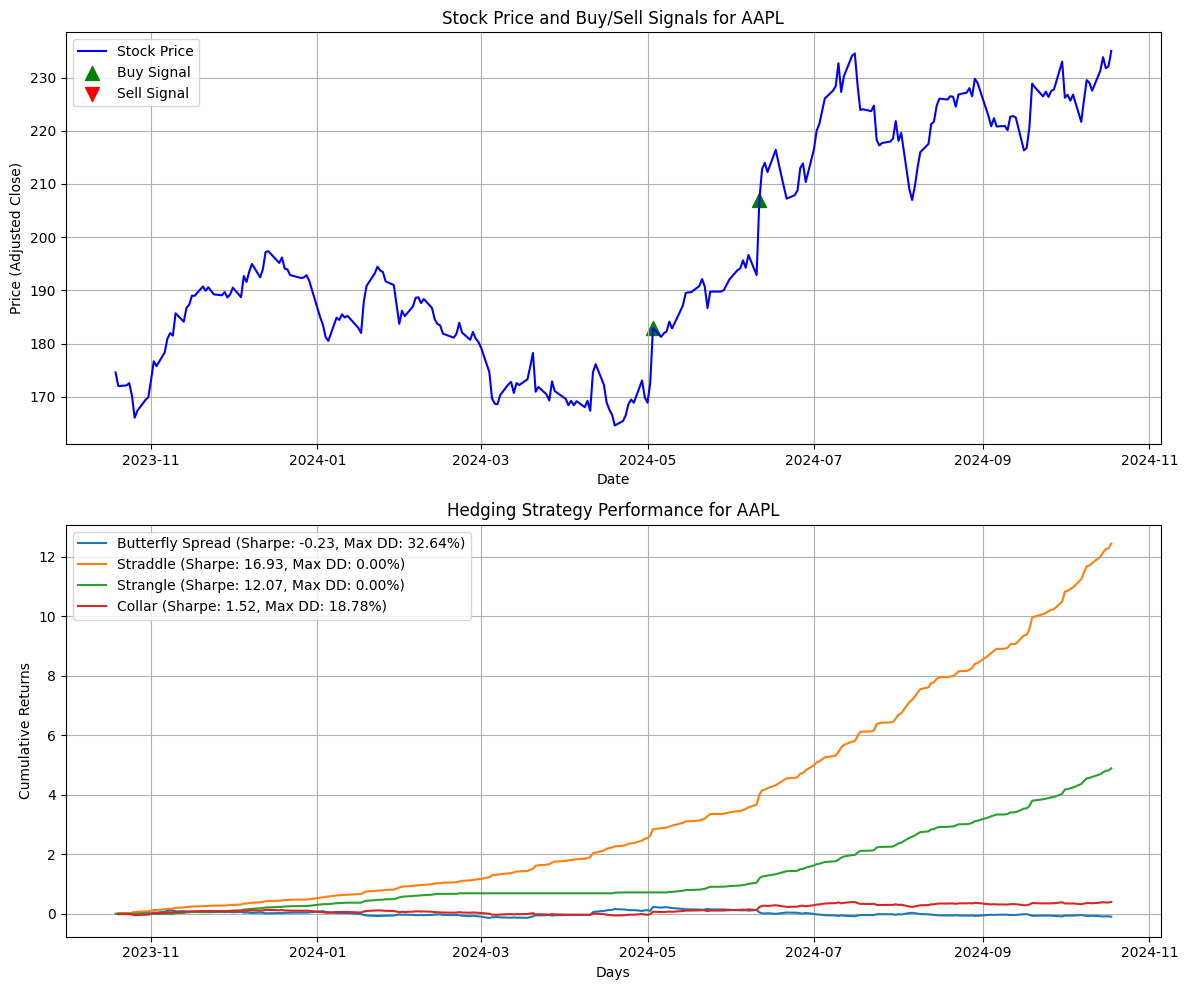

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fetch data
def fetch_data(ticker):
    stock_data = yf.download(ticker, period='1y', interval='1d')
    stock_data['Returns'] = stock_data['Adj Close'].pct_change()
    return stock_data

# Step 2: Define hedging strategies

# Butterfly Spread
def butterfly_spread(stock_data, itm=0.95, atm=1.0, otm=1.05):
    stock_data['Hedge'] = np.where(stock_data['Adj Close'] < itm * stock_data['Adj Close'].iloc[0], -1, 0)
    stock_data['Hedge'] += np.where((stock_data['Adj Close'] >= atm * stock_data['Adj Close'].iloc[0]) &
                                    (stock_data['Adj Close'] <= otm * stock_data['Adj Close'].iloc[0]), 2, -1)
    return stock_data['Hedge'] * stock_data['Returns']

# Straddle
def straddle(stock_data):
    stock_data['Hedge'] = np.abs(stock_data['Returns'])
    return stock_data['Hedge']

# Strangle
def strangle(stock_data, lower_bound=0.95, upper_bound=1.05):
    stock_data['Hedge'] = np.where((stock_data['Adj Close'] < lower_bound * stock_data['Adj Close'].iloc[0]) |
                                   (stock_data['Adj Close'] > upper_bound * stock_data['Adj Close'].iloc[0]),
                                   np.abs(stock_data['Returns']), 0)
    return stock_data['Hedge']

# Collar
def collar(stock_data, put_cost=0.02, call_premium=0.02):
    stock_data['Hedge'] = np.where(stock_data['Returns'] < -0.05, -put_cost, stock_data['Returns'])
    stock_data['Hedge'] = np.where(stock_data['Returns'] > 0.05, stock_data['Hedge'] + call_premium, stock_data['Hedge'])
    return stock_data['Hedge']

# Step 3: Evaluation metrics
def evaluate_strategy(hedge_returns):
    cumulative_returns = (1 + hedge_returns).cumprod() - 1
    sharpe_ratio = np.mean(hedge_returns) / np.std(hedge_returns) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
    return cumulative_returns, sharpe_ratio, max_drawdown

# Step 4: Plot stock price, buy/sell signals, and cumulative returns
def compare_and_plot_strategies(ticker):
    stock_data = fetch_data(ticker)

    # Apply hedging strategies
    strategies = {
        "Butterfly Spread": butterfly_spread(stock_data),
        "Straddle": straddle(stock_data),
        "Strangle": strangle(stock_data),
        "Collar": collar(stock_data)
    }

    # Plot cumulative returns
    fig, axs = plt.subplots(2, figsize=(12, 10))

    # Plot stock price in the first subplot
    axs[0].plot(stock_data.index, stock_data['Adj Close'], label='Stock Price', color='blue')

    # Adding Buy and Sell markers (using Straddle for example, you can change it to other strategies)
    buy_signals = stock_data.index[stock_data['Returns'] > 0.05]  # Example condition for Buy
    sell_signals = stock_data.index[stock_data['Returns'] < -0.05]  # Example condition for Sell
    axs[0].scatter(buy_signals, stock_data.loc[buy_signals]['Adj Close'], marker='^', color='green', label='Buy Signal', s=100)
    axs[0].scatter(sell_signals, stock_data.loc[sell_signals]['Adj Close'], marker='v', color='red', label='Sell Signal', s=100)

    axs[0].set_title(f'Stock Price and Buy/Sell Signals for {ticker}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (Adjusted Close)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot cumulative returns for each strategy in the second subplot
    for strategy_name, hedge_returns in strategies.items():
        cumulative_returns, sharpe, drawdown = evaluate_strategy(hedge_returns)

        # Plot the cumulative returns of the strategy
        axs[1].plot(cumulative_returns, label=f"{strategy_name} (Sharpe: {sharpe:.2f}, Max DD: {drawdown:.2%})")

    axs[1].set_title(f'Hedging Strategy Performance for {ticker}')
    axs[1].set_xlabel('Days')
    axs[1].set_ylabel('Cumulative Returns')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
ticker = 'AAPL'
compare_and_plot_strategies(ticker)

# Using future ARIMA prediction

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2016.093, Time=4.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1999.739, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1998.589, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1998.488, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2001.017, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2008.284, Time=2.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1995.606, Time=6.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2015.659, Time=3.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2016.076, Time=3.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2002.325, Time=1.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2015.696, Time=5.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2013.487, Time=2.99 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2015.702, Time=3.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-2017.489, Time=1.59 sec
 ARIMA(1,1,2)(0,0,0

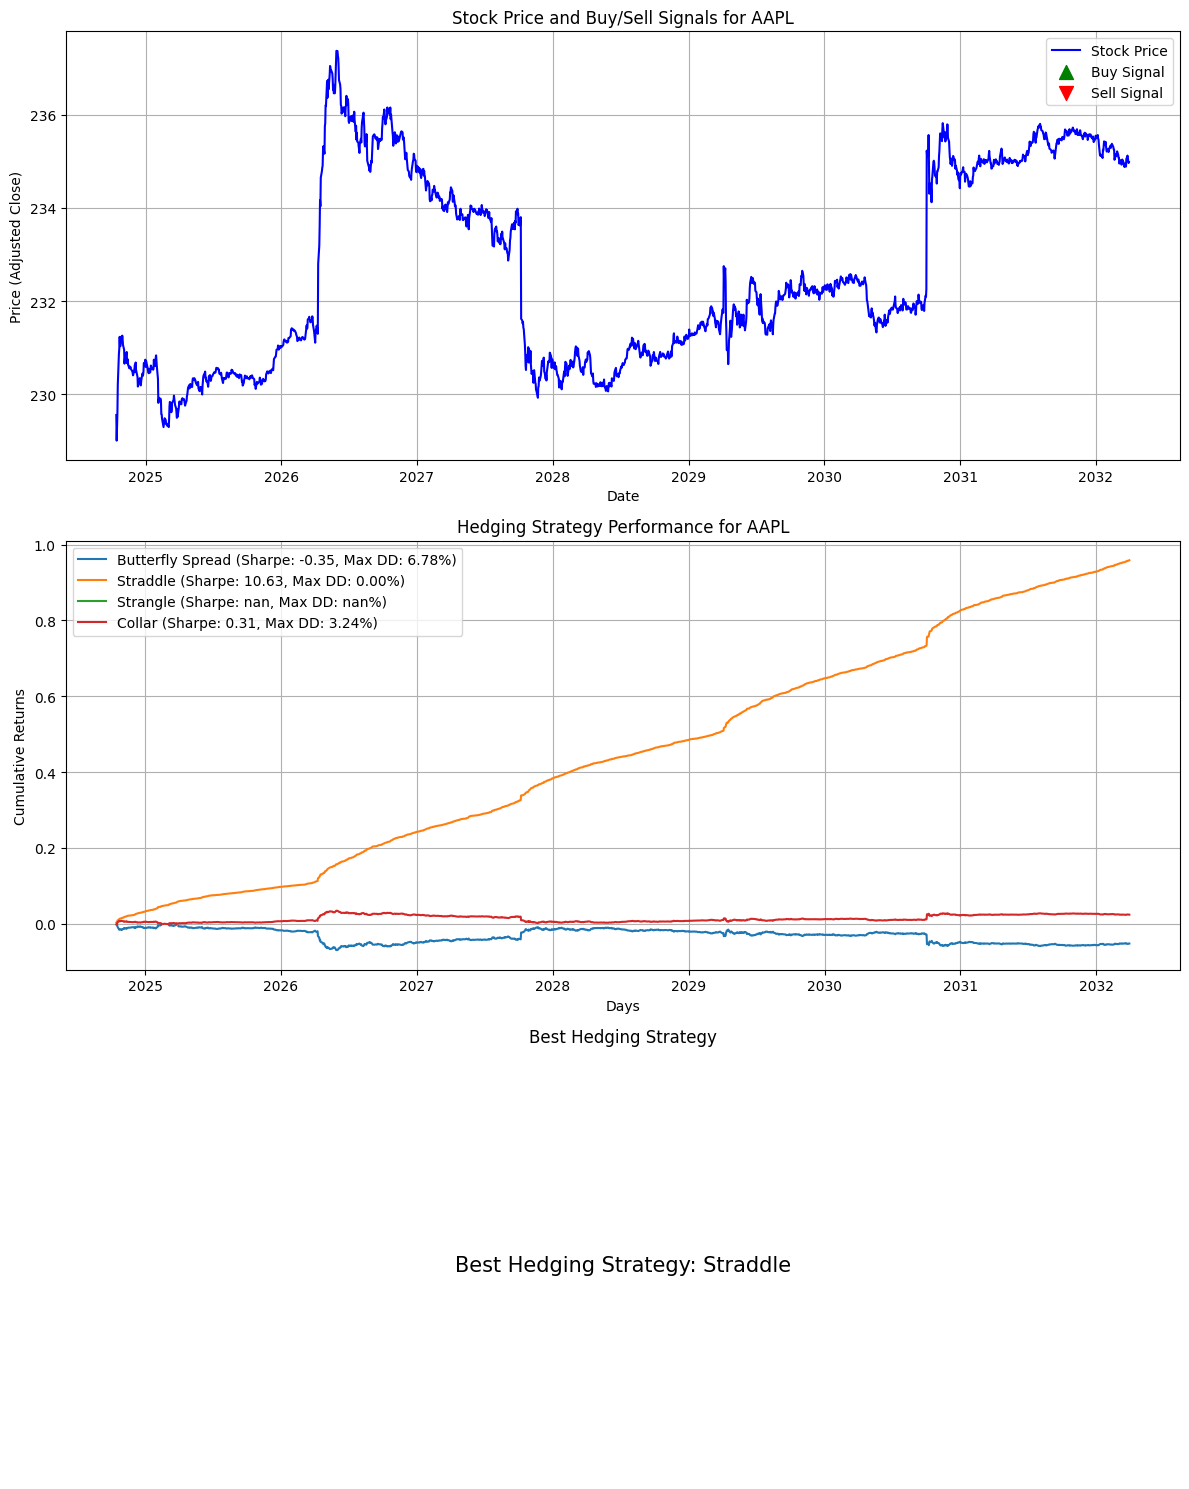

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Step 1: Fetch data
def fetch_data(ticker):
    stock_data = yf.download(ticker, period='5d', interval='1m')
    stock_data['Returns'] = stock_data['Adj Close'].pct_change()
    stock_data.index = pd.date_range(start=stock_data.index[0], periods=len(stock_data), freq='B')  # Set frequency to business days
    return stock_data

# Step 2: Define hedging strategies

import numpy as np
import pandas as pd

# Butterfly Spread
def butterfly_spread(stock_data, itm=0.95, atm=1.0, otm=1.05):

    initial_price = stock_data['Adj Close'].iloc[0]
    hedge_returns = pd.Series(index=stock_data.index)

    # Determine hedge positions based on price relative to strike prices
    hedge_returns[(stock_data['Adj Close'] < itm * initial_price)] = 1
    hedge_returns[(stock_data['Adj Close'] >= atm * initial_price) & (stock_data['Adj Close'] <= otm * initial_price)] = -2
    hedge_returns[(stock_data['Adj Close'] > otm * initial_price)] = 1

    return hedge_returns * stock_data['Returns']

# Straddle
def straddle(stock_data):
    return np.sign(stock_data['Returns']) * stock_data['Returns']

# Strangle
def strangle(stock_data, lower_bound=0.95, upper_bound=1.05):
    initial_price = stock_data['Adj Close'].iloc[0]
    hedge_returns = pd.Series(index=stock_data.index)

    # Determine hedge positions based on price relative to strike prices
    hedge_returns[(stock_data['Adj Close'] < lower_bound * initial_price) | (stock_data['Adj Close'] > upper_bound * initial_price)] = np.sign(stock_data['Returns'])

    return hedge_returns * stock_data['Returns']

# Collar
def collar(stock_data, put_cost=0.02, call_premium=0.02):

    hedge_returns = stock_data['Returns'].copy()

    # Adjust returns based on put and call options
    hedge_returns[hedge_returns < -0.05] -= put_cost
    hedge_returns[hedge_returns > 0.05] += call_premium

    return hedge_returns

# Step 3: Evaluation metrics
def evaluate_strategy(hedge_returns):
    cumulative_returns = (1 + hedge_returns).cumprod() - 1
    sharpe_ratio = np.mean(hedge_returns) / np.std(hedge_returns) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()
    return cumulative_returns, sharpe_ratio, max_drawdown


from pmdarima import auto_arima

def auto_arima_model(stock_data, forecast_period=10):
    model = auto_arima(stock_data['Adj Close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    return model

# model = auto_arima_model(stock_data)
# forecast = model.predict(n_periods=forecast_period)

# Step 4: ARIMA Model for Future Price Prediction
def predict_future_prices(stock_data, forecast_period=30):
    model = auto_arima_model(stock_data)

    model = auto_arima_model(stock_data)
    forecast = model.predict(n_periods=forecast_period)
    return forecast

# Step 5: Plot stock price, buy/sell signals, cumulative returns, and predictions
def compare_and_plot_strategies(ticker):
    stock_data = fetch_data(ticker)

    # Apply hedging strategies
    strategies = {
        "Butterfly Spread": butterfly_spread(stock_data),
        "Straddle": straddle(stock_data),
        "Strangle": strangle(stock_data),
        "Collar": collar(stock_data)
    }

    # Plot cumulative returns
    fig, axs = plt.subplots(3, figsize=(12, 15))

    # Plot stock price in the first subplot
    axs[0].plot(stock_data.index, stock_data['Adj Close'], label='Stock Price', color='blue')

    # Adding Buy and Sell markers (using Straddle for example)
    buy_signals = stock_data.index[stock_data['Returns'] > 0.05]  # Example condition for Buy
    sell_signals = stock_data.index[stock_data['Returns'] < -0.05]  # Example condition for Sell
    axs[0].scatter(buy_signals, stock_data.loc[buy_signals]['Adj Close'], marker='^', color='green', label='Buy Signal', s=100)
    axs[0].scatter(sell_signals, stock_data.loc[sell_signals]['Adj Close'], marker='v', color='red', label='Sell Signal', s=100)

    axs[0].set_title(f'Stock Price and Buy/Sell Signals for {ticker}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (Adjusted Close)')
    axs[0].legend()
    axs[0].grid(True)

    # ARIMA Prediction
    forecast_period = 1  # Number of days to predict
    forecast = predict_future_prices(stock_data, forecast_period)

    # Extend the index for the forecast period
    future_dates = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='B')
    axs[0].plot(future_dates, forecast, label='ARIMA Forecast', color='orange', linestyle='solid')

    # Plot cumulative returns for each strategy in the second subplot
    for strategy_name, hedge_returns in strategies.items():
        cumulative_returns, sharpe, drawdown = evaluate_strategy(hedge_returns)

        # Plot the cumulative returns of the strategy
        axs[1].plot(cumulative_returns, label=f"{strategy_name} (Sharpe: {sharpe:.2f}, Max DD: {drawdown:.2%})")

    axs[1].set_title(f'Hedging Strategy Performance for {ticker}')
    axs[1].set_xlabel('Days')
    axs[1].set_ylabel('Cumulative Returns')
    axs[1].legend()
    axs[1].grid(True)

    # Determine the best strategy based on the Sharpe Ratio
    best_strategy = max(strategies.keys(), key=lambda x: evaluate_strategy(strategies[x])[1])
    axs[2].text(0.5, 0.5, f'Best Hedging Strategy: {best_strategy}', fontsize=15, ha='center', va='center')
    axs[2].set_title('Best Hedging Strategy')
    axs[2].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Example usage
ticker = 'AAPL'
compare_and_plot_strategies(ticker)